In [12]:
import sys
sys.path.append('..')
from Comms_System import Comms_System, SNR_plot
import numpy as np
import matplotlib.pyplot as plt
from ML_components import load_params
from Network import NeuralNetwork
import scipy
import torch
from filters import butter_lowpass
import torchaudio

In [3]:
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 10000
symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
#figsize=(13, 8)
figsize=(6.4, 4.8)
#cutoffs = ['2', '1', '05'] #'03'] # '02']
#cutoff_ints = [2, 1, 0.5] # 0.3] # 0.2]
cutoffs = ['0.675']
cutoff_ints = [0.675]
#figsize=(6.4, 4.8)

# Inspect learned filters from Joint Training

### Sender Weights

Cutoff Frequency = 0.675


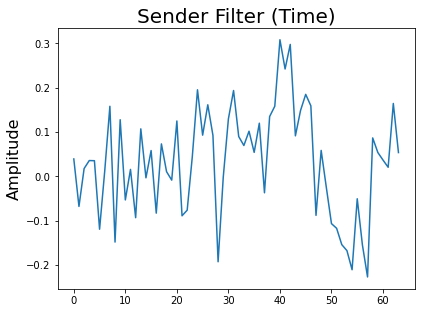

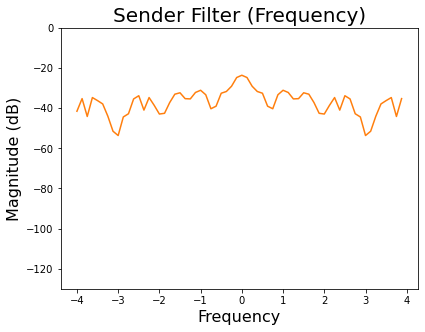

_________________________________________________________



In [4]:
for cutoff, c_int in zip(cutoffs, cutoff_ints):
    print('Cutoff Frequency =', c_int)
    path = '../Joint_Models/'
    net = torch.load(path + 'SenderButter' + cutoff)
    learned_filter = list(net.parameters())[0].detach()[0][0]
    learned_filter = learned_filter / torch.sqrt(torch.sum(torch.square(learned_filter))) # normalize
    plt.figure(figsize=figsize)
    plt.title('Sender Filter (Time)', fontsize=20)
    plt.plot(learned_filter)
    plt.ylabel('Amplitude', fontsize=16)
    plt.show()
    plt.figure(figsize=figsize)
    plt.title('Sender Filter (Frequency)', fontsize=20)
    plt.magnitude_spectrum(learned_filter, Fs=CS.m, color='C1', sides='twosided', scale='dB')
    plt.xlabel('Frequency', fontsize=16)
    plt.ylabel('Magnitude (dB)', fontsize=16)
    plt.ylim([-130, 0])
    plt.show()
    print('_________________________________________________________')
    print()

### Receiver Weights

Cutoff Frequency = 0.675


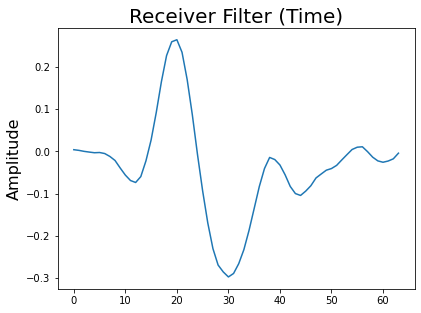

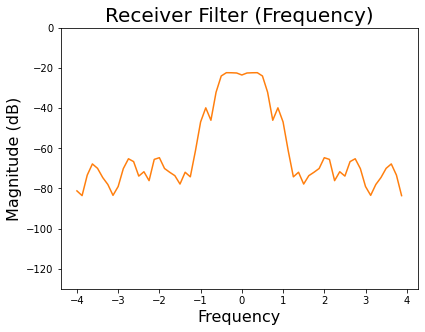

_________________________________________________________



In [5]:
for cutoff, c_int in zip(cutoffs, cutoff_ints):
    print('Cutoff Frequency =', c_int)
    path = '../Joint_Models/'
    net = torch.load(path + 'ReceiverButter' + cutoff)
    learned_filter = list(net.parameters())[0].detach()[0][0]
    learned_filter = learned_filter / torch.sqrt(torch.sum(torch.square(learned_filter))) # normalize
    plt.figure(figsize=figsize)
    plt.title('Receiver Filter (Time)', fontsize=20)
    plt.plot(learned_filter)
    plt.ylabel('Amplitude', fontsize=16)
    plt.show()
    plt.figure(figsize=figsize)
    plt.title('Receiver Filter (Frequency)', fontsize=20)
    plt.magnitude_spectrum(learned_filter, Fs=CS.m, color='C1', sides='twosided', scale='dB')
    plt.xlabel('Frequency', fontsize=16)
    plt.ylabel('Magnitude (dB)', fontsize=16)
    plt.ylim([-130, 0])
    plt.show()
    print('_________________________________________________________')
    print()

### Total Impulse Response of Sender (i.e. sender filter convolved with LPF)

Cutoff Frequency = 0.675


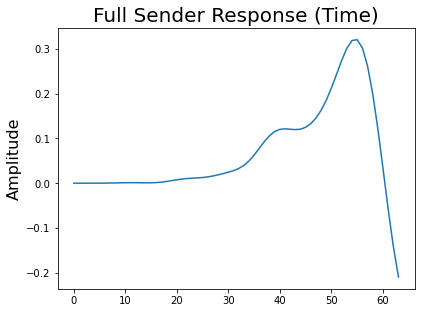

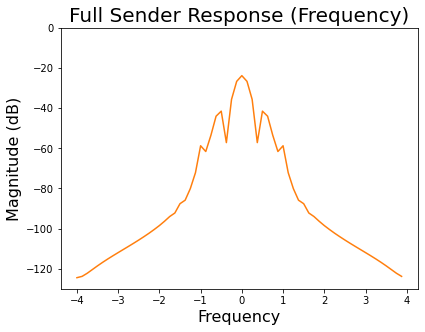

_________________________________________________________



In [31]:
for cutoff, c_int in zip(cutoffs, cutoff_ints):
    print('Cutoff Frequency =', c_int)
    b, a = butter_lowpass(cutoff_freq=c_int, sampling_rate=CS.m, order=10)
    path = '../Joint_Models/'
    net = torch.load(path + 'SenderButter' + cutoff)
    learned_filter = list(net.parameters())[0].detach()[0][0]
    learned_filter = learned_filter / torch.sqrt(torch.sum(torch.square(learned_filter))) # normalize
    total_sender_response = scipy.signal.lfilter(b, a, learned_filter)
    total_sender_response = total_sender_response / np.sqrt(np.sum(np.square(total_sender_response))) # normalize
    plt.figure(figsize=figsize)
    plt.title('Full Sender Response (Time)', fontsize=20)
    plt.plot(total_sender_response)
    plt.ylabel('Amplitude', fontsize=16)
    plt.show()
    plt.figure(figsize=figsize)
    plt.title('Full Sender Response (Frequency)', fontsize=20)
    plt.magnitude_spectrum(total_sender_response, Fs=8, scale='dB', sides='twosided', color='C1')
    plt.xlabel('Frequency', fontsize=16)
    plt.ylabel('Magnitude (dB)', fontsize=16)
    plt.ylim([-130, 0])
    plt.show()
    print('_________________________________________________________')
    print()

### Total Response of Whole System

Cutoff Frequency = 0.675


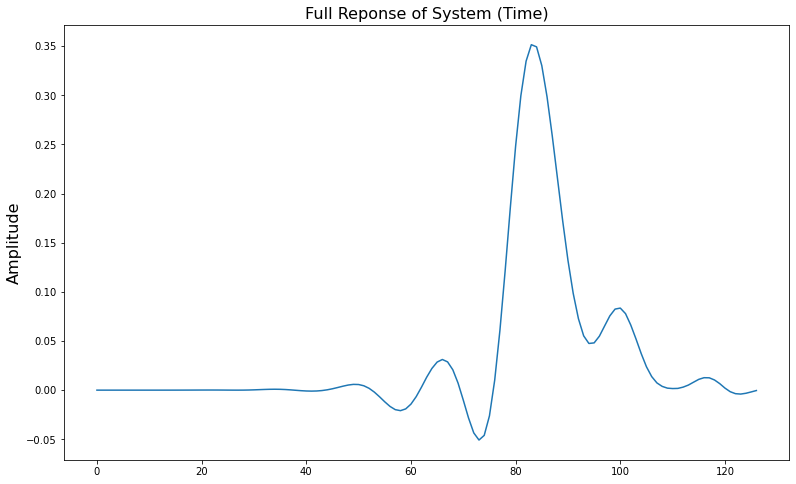

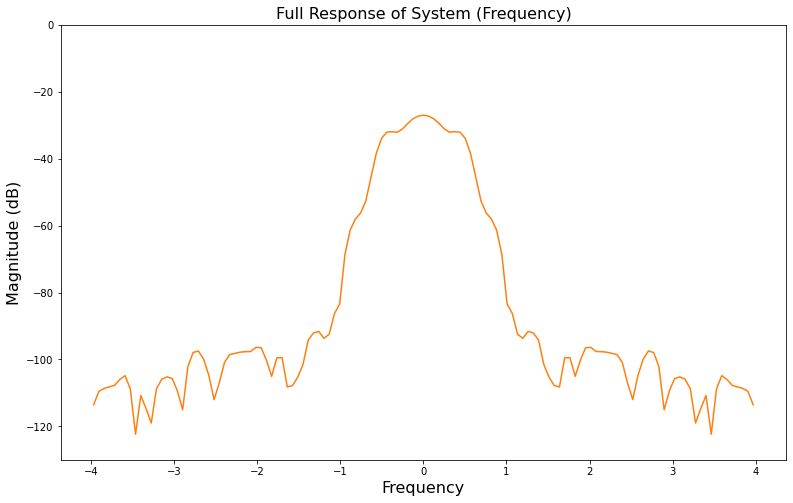

In [62]:
for cutoff, c_int in zip(cutoffs, cutoff_ints):
    print('Cutoff Frequency =', c_int)
    b, a = butter_lowpass(cutoff_freq=0.675, sampling_rate=CS.m, order=10)
    path = '../Joint_Models/'
    tx_net = torch.load(path + 'SenderButter0.675')
    rx_net = torch.load(path + 'ReceiverButter0.675')
    learned_tx_filter = list(tx_net.parameters())[0].detach()[0][0]
    learned_rx_filter = list(rx_net.parameters())[0].detach()[0][0]
    total_sender_response = scipy.signal.lfilter(b, a, learned_tx_filter)
    #total_sender_response = total_sender_response / np.sqrt(np.sum(np.square(total_sender_response))) # normalize
    full_response = np.convolve(total_sender_response, learned_rx_filter)
    full_response = full_response / np.sqrt(np.sum(np.square(full_response))) # normalize
    plt.figure(figsize=(13,8))
    plt.title('Full Reponse of System (Time)', fontsize=16)
    plt.plot(-full_response)
    plt.ylabel('Amplitude', fontsize=16)
    plt.grid(False)
    plt.show()
    plt.figure(figsize=(13,8))
    plt.title('Full Response of System (Frequency)', fontsize=16)
    plt.xlabel('Frequency', fontsize=16)
    plt.ylabel('Magnitude (dB)', fontsize=16)
    plt.ylim([-130, 0])
    plt.magnitude_spectrum(full_response, Fs=8, scale='dB', sides='twosided', color='C1')
    plt.show()